<a href="https://colab.research.google.com/github/shinebalance/DL_notes/blob/master/GDL_code_study/7_2~3_LSTM_with_Attention%E3%81%A7%E4%BD%9C%E6%9B%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7-2　LSTM with Attentionで作曲
* モノフォニックな作曲をやってみよう
 * GPU使います

> [ChoasさんRepo](https://github.com/chaos44/generative_deep_learning/tree/main/chap7)を起点に編集

## 事前準備類

In [ ]:
# tensorflow 2のブランチを指定して作者レポジトリをColabコンテナ内にクローン
!git clone -b tensorflow_2 https://github.com/davidADSP/GDL_code.git

Cloning into 'GDL_code'...
remote: Enumerating objects: 391, done.
remote: Total 391 (delta 0), reused 0 (delta 0), pack-reused 391
Receiving objects: 100% (391/391), 22.13 MiB | 39.48 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [ ]:
# クローンしたディレクトリ内に移動
# %をつけてマジックコマンドとして実行する必要があるので注意(!だとサブプロセスの中でディレクトリが変わるだけ)
%cd GDL_code/

[Errno 2] No such file or directory: 'GDL_code/'
/content/GDL_code


In [ ]:
# pip install --upgrade music21

     |████████████████████████████████| 19.2MB 47.1MB/s 
  Created wheel for music21: filename=music21-6.3.0-cp36-none-any.whl size=21888021 sha256=1bd67fe46291d0c4d62134db666b0b63f3ef651e5e867779c52f32ed538c243c
  Stored in directory: /root/.cache/pip/wheels/02/e8/2c/eed32afec2b6c6f945a17280c4e4df1cf2e8cd15ebe1025680
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
from music21 import converter, chord, note

### データの取得

In [ ]:
# 取得したいリンク先のリスト(ちょっと無理やりですが…)
# ! wget http://www.jsbach.net/midi/midi_solo_cello.html
! cat ./midi_solo_cello.html | grep .mid | grep cs1 | cut -d '"' -f 4

cs1-1pre.mid
cs1-2all.mid
cs1-3cou.mid
cs1-4sar.mid
cs1-5men.mid
cs1-6gig.mid


In [ ]:
! wget http://www.jsbach.net/midi/cs1-1pre.mid -P "./data/cello/"
! wget http://www.jsbach.net/midi/cs1-2all.mid -P "./data/cello/"
! wget http://www.jsbach.net/midi/cs1-3cou.mid -P "./data/cello/"
! wget http://www.jsbach.net/midi/cs1-4sar.mid -P "./data/cello/"
! wget http://www.jsbach.net/midi/cs1-5men.mid -P "./data/cello/"
! wget http://www.jsbach.net/midi/cs1-6gig.mid -P "./data/cello/"

--2021-01-10 11:42:55--  http://www.jsbach.net/midi/cs1-1pre.mid
Resolving www.jsbach.net (www.jsbach.net)... 98.129.229.34
Connecting to www.jsbach.net (www.jsbach.net)|98.129.229.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4922 (4.8K) [audio/midi]
Saving to: ‘./data/cello/cs1-1pre.mid’

cs1-1pre.mid        100%[===================>]   4.81K  --.-KB/s    in 0s      

2021-01-10 11:42:55 (624 MB/s) - ‘./data/cello/cs1-1pre.mid’ saved [4922/4922]

--2021-01-10 11:42:55--  http://www.jsbach.net/midi/cs1-2all.mid
Resolving www.jsbach.net (www.jsbach.net)... 98.129.229.34
Connecting to www.jsbach.net (www.jsbach.net)|98.129.229.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7088 (6.9K) [audio/midi]
Saving to: ‘./data/cello/cs1-2all.mid’

cs1-2all.mid        100%[===================>]   6.92K  --.-KB/s    in 0s      

2021-01-10 11:42:55 (753 MB/s) - ‘./data/cello/cs1-2all.mid’ saved [7088/7088]

--2021-01-10 11:42:55--  http://ww

## **Compose: Training a model to generate music**



In [ ]:
import os
import pickle
import numpy
from music21 import note, chord

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

### **Set parameters**

In [ ]:
# run params
section = 'compose'
run_id = '0006'
music_name = 'cello'

run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', music_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

### **Extract the notes**

In [ ]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f)

6 files in total
1 Parsing data/cello/cs1-4sar.mid
2 Parsing data/cello/cs1-3cou.mid
3 Parsing data/cello/cs1-2all.mid
4 Parsing data/cello/cs1-6gig.mid
5 Parsing data/cello/cs1-1pre.mid
6 Parsing data/cello/cs1-5men.mid


### **Create the lookup tables**

In [ ]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [ ]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.B2': 1,
 'A2.D3': 2,
 'A2.E-3': 3,
 'A2.E3.A3': 4,
 'A2.E3.C4': 5,
 'A3': 6,
 'B-2': 7,
 'B-3': 8,
 'B2': 9,
 'B2.C3': 10,
 'B2.D3': 11,
 'B3': 12,
 'C#2': 13,
 'C#3': 14,
 'C#4': 15,
 'C2': 16,
 'C2.G2.E3': 17,
 'C3': 18,
 'C3.D3': 19,
 'C4': 20,
 'D2': 21,
 'D2.A2.F#3': 22,
 'D2.A2.F#3.C4': 23,
 'D3': 24,
 'D3.A3': 25,
 'D4': 26,
 'E-2': 27,
 'E-3': 28,
 'E-4': 29,
 'E2': 30,
 'E3': 31,
 'E3.A3': 32,
 'E3.B3': 33,
 'E3.F3': 34,
 'E4': 35,
 'F#2': 36,
 'F#3': 37,
 'F#4': 38,
 'F2': 39,
 'F3': 40,
 'F4': 41,
 'G#2': 42,
 'G#3': 43,
 'G2': 44,
 'G2.B3.G4': 45,
 'G2.D3.B3': 46,
 'G2.E3.B3': 47,
 'G2.E3.C4': 48,
 'G2.G3': 49,
 'G3': 50,
 'G4': 51,
 'START': 52}

In [ ]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 0.25: 1,
 0.5: 2,
 Fraction(2, 3): 3,
 0.75: 4,
 1.0: 5,
 1.25: 6,
 1.5: 7,
 2.0: 8,
 3.0: 9,
 4.0: 10}

### **Prepare the sequences used by the Neural Network**

In [ ]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [ ]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52
 52 52 52 52 52 52 52 52]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0.]
duration output
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


### **Create the structure of the neural network**

In [ ]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    5300        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1100        input_2[0][0]                    
______________________________________________________________________________________________

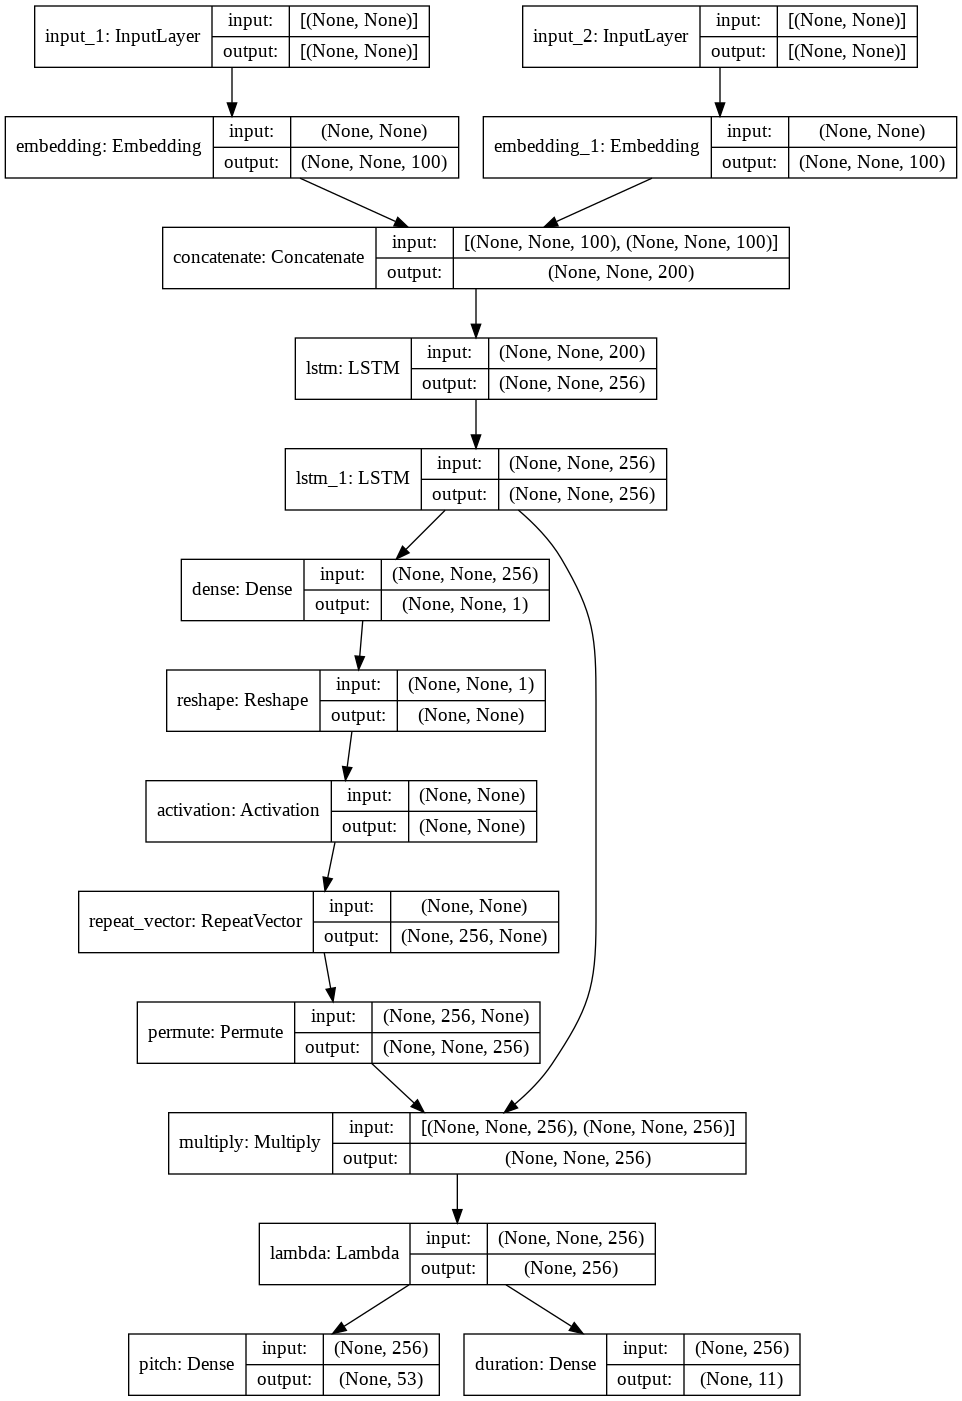

In [ ]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

### **Train the neural network**

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
# model.fit(network_input, network_output
#           , epochs=2000000, batch_size=32
#           , validation_split = 0.2
#           , callbacks=callbacks_list
#           , shuffle=True
#          )

model.fit(network_input, network_output
          , epochs=20, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/20
97/97 [==============================] - 11s 20ms/step - loss: 3.9291 - pitch_loss: 3.0753 - duration_loss: 0.8537 - val_loss: 4.0724 - val_pitch_loss: 3.2571 - val_duration_loss: 0.8153
Epoch 2/20
97/97 [==============================] - 1s 12ms/step - loss: 3.4389 - pitch_loss: 2.8287 - duration_loss: 0.6102 - val_loss: 5.1024 - val_pitch_loss: 3.7884 - val_duration_loss: 1.3140
Epoch 3/20
97/97 [==============================] - 1s 11ms/step - loss: 3.2329 - pitch_loss: 2.7413 - duration_loss: 0.4916 - val_loss: 3.7597 - val_pitch_loss: 3.1030 - val_duration_loss: 0.6567
Epoch 4/20
97/97 [==============================] - 1s 13ms/step - loss: 3.2223 - pitch_loss: 2.7146 - duration_loss: 0.5077 - val_loss: 3.8031 - val_pitch_loss: 3.1037 - val_duration_loss: 0.6993
Epoch 5/20
97/97 [==============================] - 1s 11ms/step - loss: 3.2027 - pitch_loss: 2.7086 - duration_loss: 0.4941 - val_loss: 3.8143 - val_pitch_loss: 3.1132 - val_duration_loss: 0.7011
Epoch 6/20
97/

In [ ]:
# モデルの確認
! ls /content/GDL_code/run/compose/0006_cello/weights

weights.h5
weights-improvement-01-3.6744-bigger.h5
weights-improvement-02-3.3894-bigger.h5
weights-improvement-03-3.2528-bigger.h5
weights-improvement-04-3.1789-bigger.h5
weights-improvement-05-3.1349-bigger.h5
weights-improvement-06-3.0928-bigger.h5
weights-improvement-07-3.0500-bigger.h5
weights-improvement-08-2.9986-bigger.h5
weights-improvement-09-2.9627-bigger.h5
weights-improvement-10-2.9031-bigger.h5
weights-improvement-11-2.8412-bigger.h5
weights-improvement-12-2.7657-bigger.h5
weights-improvement-13-2.6818-bigger.h5
weights-improvement-14-2.5998-bigger.h5
weights-improvement-15-2.5189-bigger.h5
weights-improvement-16-2.4333-bigger.h5
weights-improvement-17-2.3541-bigger.h5
weights-improvement-18-2.2682-bigger.h5
weights-improvement-19-2.1781-bigger.h5
weights-improvement-20-2.0812-bigger.h5


# 7-3 実行

## imports

In [ ]:
import pickle as pkl
import time
# import os
import numpy as np
# import sys
# from music21 import instrument, note, stream, chord, duration
from music21 import instrument, stream, duration  # 推論に必要分のみ
# from models.RNNAttention import create_network, sample_with_temp
from models.RNNAttention import sample_with_temp  # 推論に必要分のみ

import matplotlib.pyplot as plt


# parameters

In [ ]:
# run params
section = 'compose'
run_id = '0006'
music_name = 'cello'
run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])

# model params
embed_size = 100
rnn_units = 256
use_attention = True


## load the lookup tables

In [ ]:

store_folder = os.path.join(run_folder, 'store')

with open(os.path.join(store_folder, 'distincts'), 'rb') as filepath:
    distincts = pkl.load(filepath)
    note_names, n_notes, duration_names, n_durations = distincts

with open(os.path.join(store_folder, 'lookups'), 'rb') as filepath:
    lookups = pkl.load(filepath)
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups

## build the model

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')
weights_file = 'weights.h5'

model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)

# Load the weights to each node
weight_source = os.path.join(weights_folder,weights_file)
model.load_weights(weight_source)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    5300        input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 100)    1100        input_4[0][0]                    
____________________________________________________________________________________________

## build your own phrase

In [ ]:
# prediction params
notes_temp=0.5
duration_temp = 0.5
max_extra_notes = 50
max_seq_len = 32
seq_len = 32

# notes = ['START', 'D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3']
# durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]


# notes = ['START', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3','F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3']
# durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]


notes = ['START']
durations = [0]

if seq_len is not None:
    notes = ['START'] * (seq_len - len(notes)) + notes
    durations = [0] * (seq_len - len(durations)) + durations


sequence_length = len(notes)

## Generate notes from the neural network based on a sequence of notes

In [ ]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []

overall_preds = []

for n, d in zip(notes,durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]
    
    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)
    
    prediction_output.append([n, d])
    
    if n != 'START':
        midi_note = note.Note(n)

        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        overall_preds.append(new_note)


att_matrix = np.zeros(shape = (max_extra_notes+sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):

    prediction_input = [
        np.array([notes_input_sequence])
        , np.array([durations_input_sequence])
       ]

    notes_prediction, durations_prediction = model.predict(prediction_input, verbose=0)
    if use_attention:
        att_prediction = att_model.predict(prediction_input, verbose=0)[0]
        att_matrix[(note_index-len(att_prediction)+sequence_length):(note_index+sequence_length), note_index] = att_prediction
    
    new_note = np.zeros(128)
    
    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i
            
        except:
            pass
        
    overall_preds.append(new_note)
            
    
    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)
    

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]
    
    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)
    
    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]
        
#     print(note_result)
#     print(duration_result)
        
    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds)) 
print('Generated sequence of {} notes'.format(len(prediction_output)))

Generated sequence of 82 notes


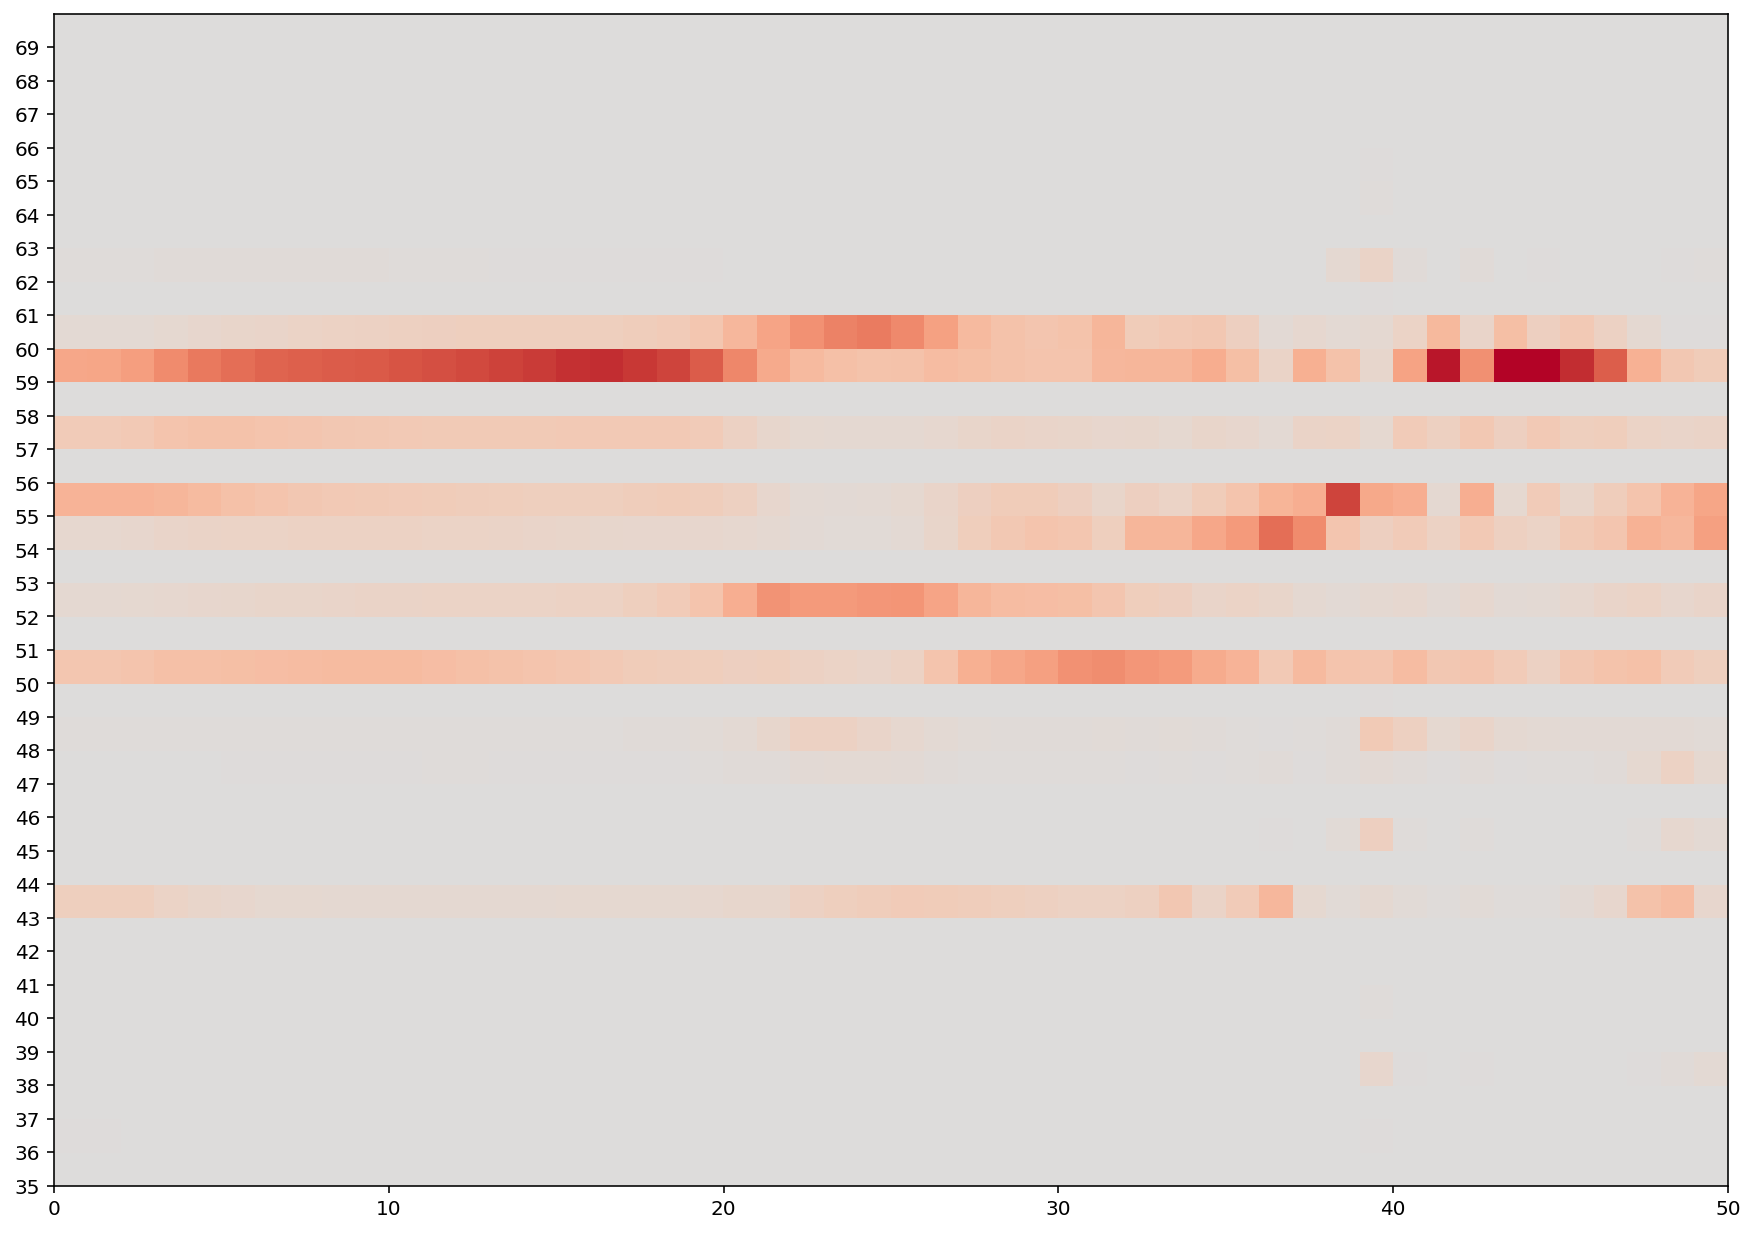

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_yticks([int(j) for j in range(35,70)])

plt.imshow(overall_preds[35:70,:], origin="lower", cmap='coolwarm', vmin = -0.5, vmax = 0.5, extent=[0, max_extra_notes, 35,70]
          
          )

## convert the output from the prediction to notes and create a midi file from the notes 

In [ ]:
output_folder = os.path.join(run_folder, 'output')

midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)



midi_stream = midi_stream.chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write('midi', fp=os.path.join(output_folder, 'output-' + timestr + '.mid'))

'run/compose/0006_cello/output/output-20210110-120222.mid'

DLしてローカルで聞いてみるのもお勧め（Mac OSだとGaragebandで再生できる）

In [ ]:
# DLが走るセル
from google.colab import files
# files.download('実行結果のパスを入れる')
files.download('run/compose/0006_cello/output/output-20210110-120222.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

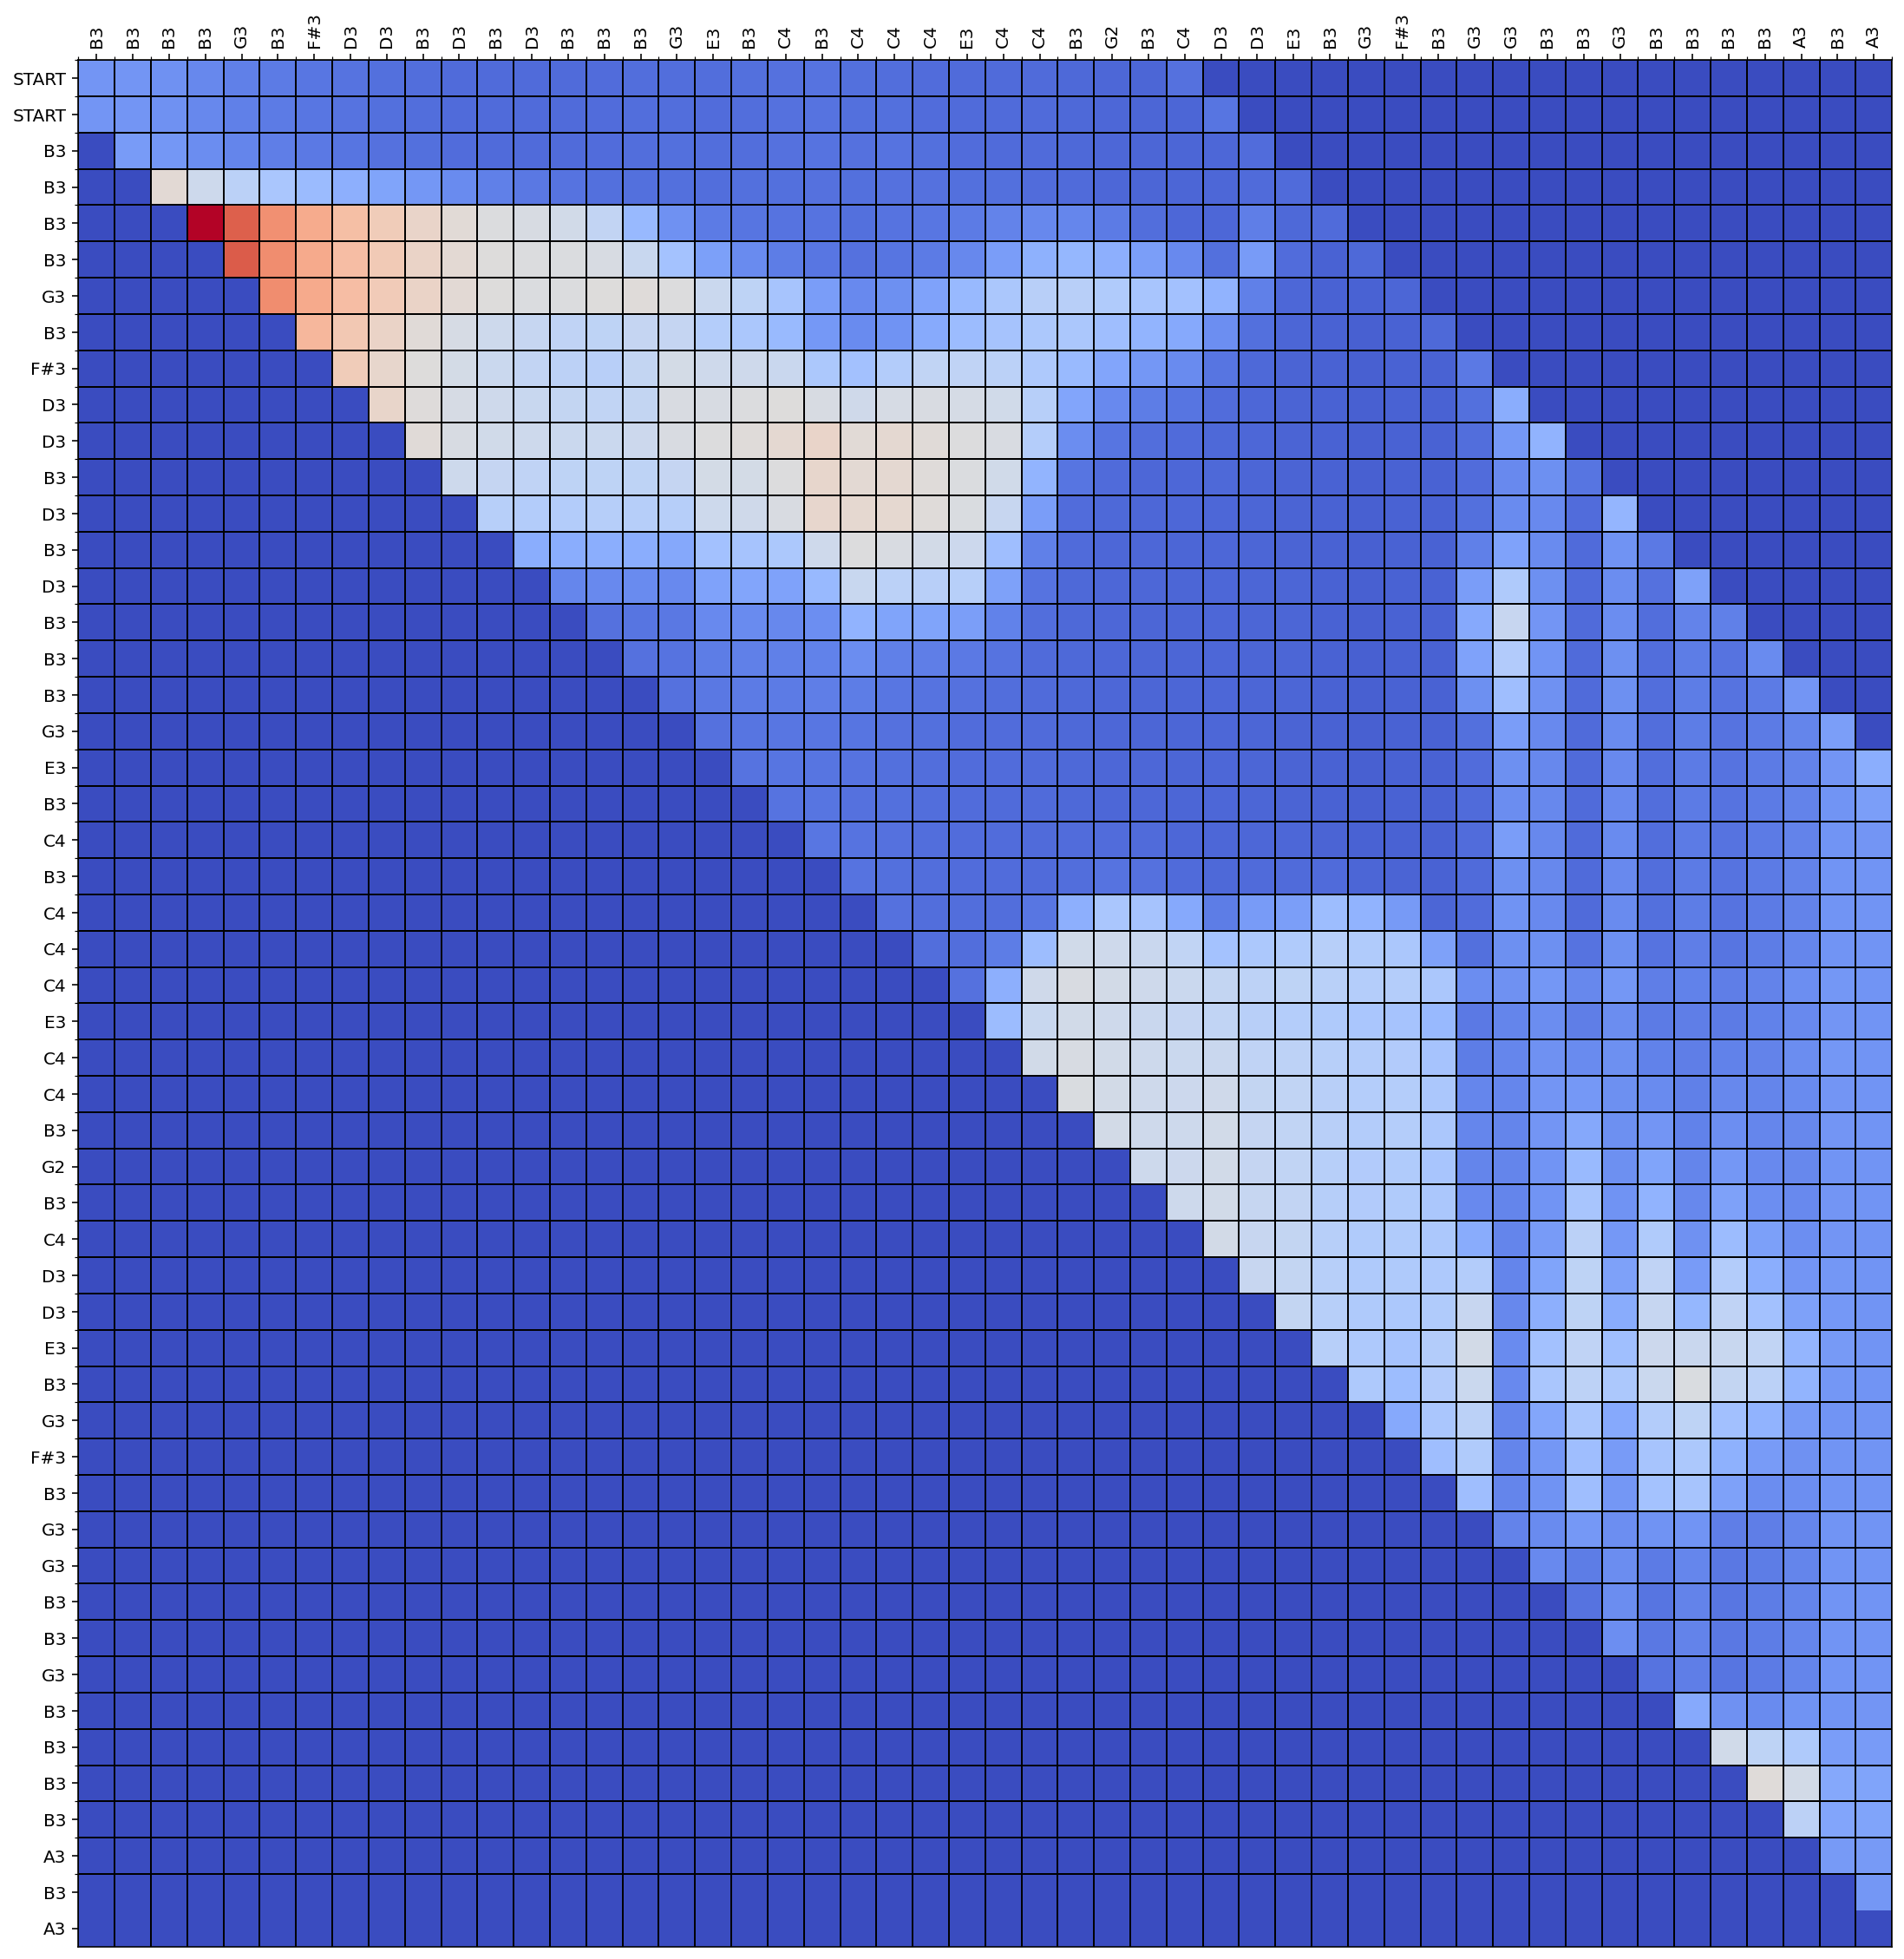

In [ ]:
## attention plot
if use_attention:
    fig, ax = plt.subplots(figsize=(20,20))

    im = ax.imshow(att_matrix[(seq_len-2):,], cmap='coolwarm', interpolation='nearest')


    

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(prediction_output)- seq_len, 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    
    
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(prediction_output) - seq_len))
    ax.set_yticks(np.arange(len(prediction_output)- seq_len+2))
    # ... and label them with the respective list entries
    ax.set_xticklabels([n[0] for n in prediction_output[(seq_len):]])
    ax.set_yticklabels([n[0] for n in prediction_output[(seq_len - 2):]])

    # ax.grid(color='black', linestyle='-', linewidth=1)

    ax.xaxis.tick_top()


    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
             rotation_mode="anchor")

    plt.show()

# 以上